In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# load train data to build model
df = pd.read_csv('data/train.csv')
del df['type']
df.head()

,category,rating,reviews,installs,price,content_rating,app_size,last_updated_encoded
0,Tools,5.00000,1.09861,4.60517,1.09527,Everyone,23.00000,3031
1,Education/Business,4.10000,4.24850,6.21461,-0.01005,Everyone,3.50000,1337
2,Tools,4.40000,7.48099,9.21034,0.68813,Everyone,4.10000,2834
3,Lifestyle,4.30000,11.77223,13.81551,1.09527,Everyone 10+,23.00000,2232
4,Tools,4.60000,4.52179,6.90776,4.38190,Everyone,32.00000,3090


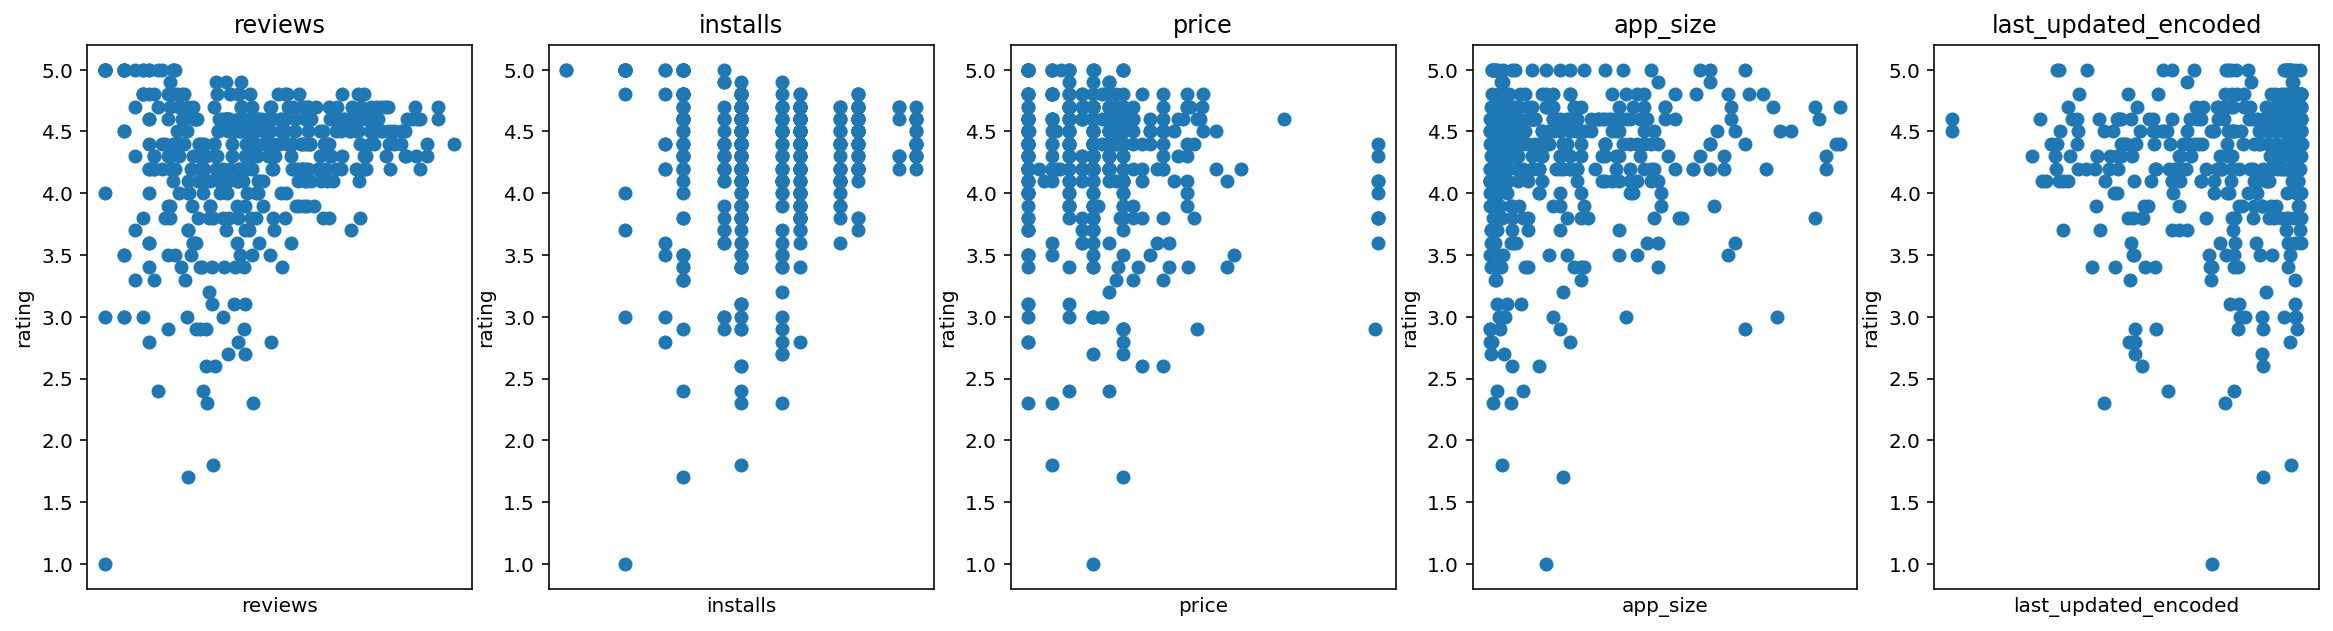

In [3]:
#scatter plots for numerical variables

plt.figure(figsize=(20, 5))
numerical_variables = ['reviews','installs','price','app_size','last_updated_encoded']

for i, col in enumerate(numerical_variables):
    plt.subplot(1, 5, i+1)
    x = df[col]
    y = df['rating']
    plt.plot(x, y, 'o')
    plt.xticks([])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('rating')

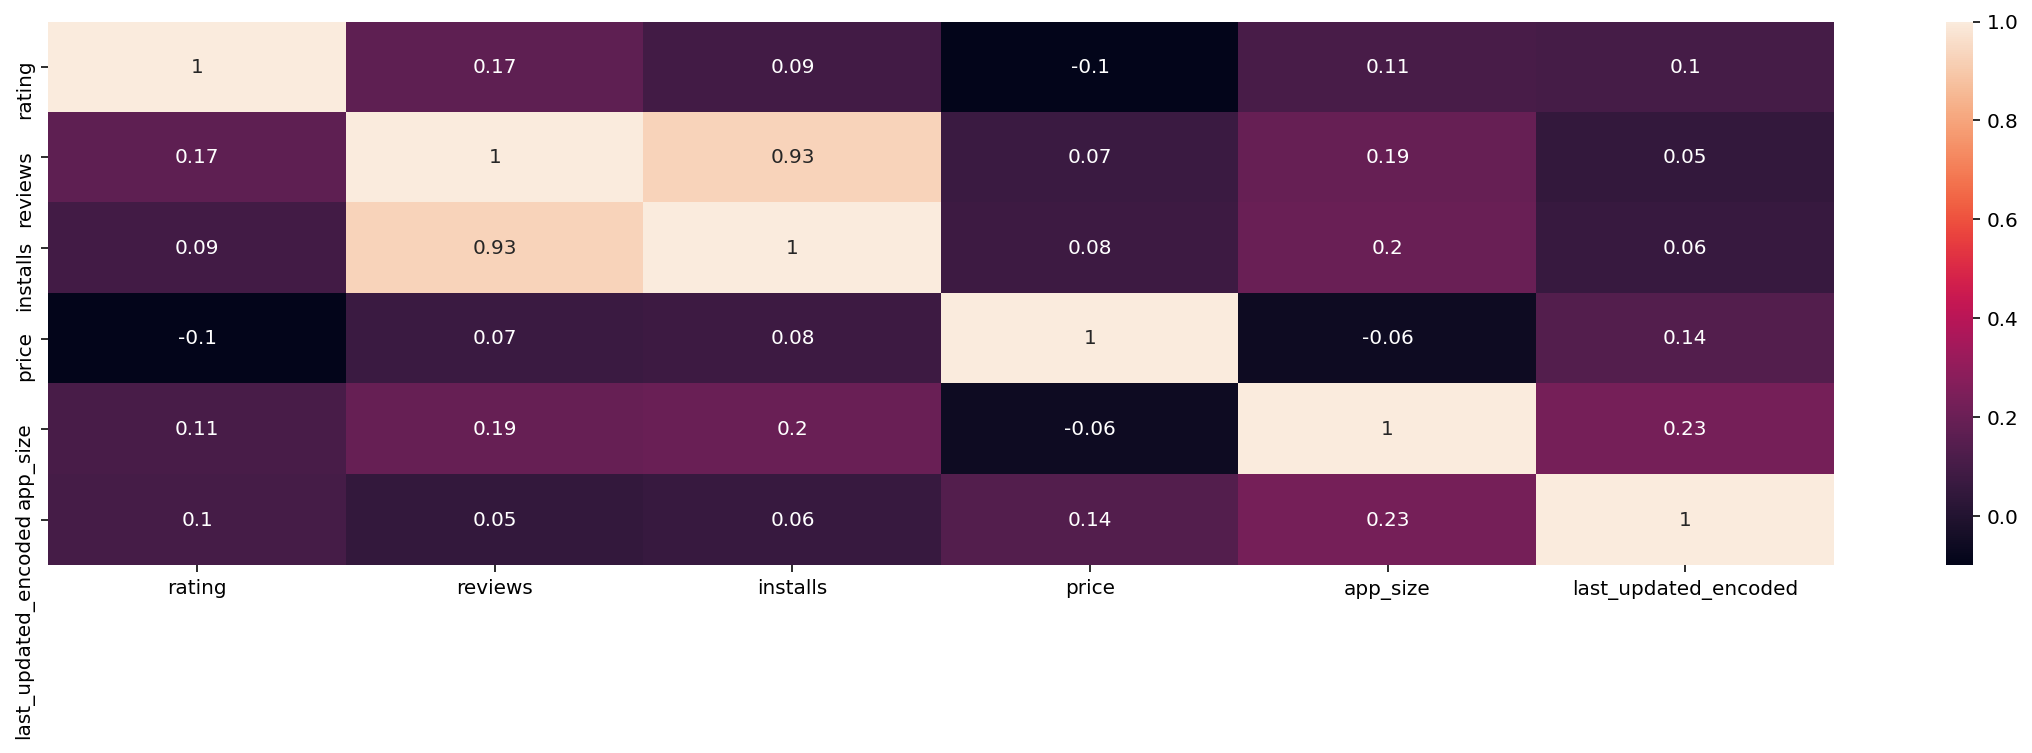

In [4]:
#checking multicollinearity.From heat map seems like reviews and installs are correlated.
import seaborn as sns
correlation_matrix = df.corr().round(2)
plt.figure(figsize = (20,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
#the vif scores are checked here
from patsy import dmatrices
ystr = 'rating'
xstr = '+'.join([col for col in df.columns if col != ystr])
y, X = dmatrices(f'{ystr}~{xstr}', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                        features
0     52.35718                       Intercept
1      3.45785       category[T.Entertainment]
2      4.17756           category[T.Lifestyle]
3      1.56299              category[T.Social]
4      4.30420               category[T.Tools]
5      1.07773  content_rating[T.Everyone 10+]
6      1.02746    content_rating[T.Mature 17+]
7      1.16841          content_rating[T.Teen]
8      8.33848                         reviews
9      8.14804                        installs
10     1.10747                           price
11     1.26820                        app_size
12     1.09946            last_updated_encoded


In [6]:
ystr = 'rating'
xstr = '+'.join([col for col in df.columns if col != ystr])
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.045
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           7.24e-08
Time:                        15:07:22   Log-Likelihood:                -342.85
No. Observations:                 432   AIC:                             711.7
Df Residuals:                     419   BIC:                             764.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

#### category has only one(tools) which has p value less than 0.05. So, it is still significant.
#### content-rating not significant
#### app-size not significant


In [7]:
# The partial and sequential anova to re-confirm the t- test values
partial = sm.stats.anova_lm(model, typ=2)
seq = sm.stats.anova_lm(model, typ=1)

print('~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

print('\n~~~~~~~ Sequential ANOVA ~~~~~~~')
print(seq)

~~~~~~~ Partial ANOVA ~~~~~~~
                        sum_sq        df        F  PR(>F)
category               3.78662   4.00000  3.20668 0.01304
content_rating         1.16354   3.00000  1.31378 0.26939
reviews                7.54804   1.00000 25.56809 0.00000
installs               5.06834   1.00000 17.16840 0.00004
price                  1.83592   1.00000  6.21895 0.01302
app_size               0.10513   1.00000  0.35612 0.55099
last_updated_encoded   1.65751   1.00000  5.61461 0.01826
Residual             123.69436 419.00000      nan     nan

~~~~~~~ Sequential ANOVA ~~~~~~~
                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   4.32670  1.08167  3.66405 0.00602
content_rating         3.00000   1.80838  0.60279  2.04189 0.10738
reviews                1.00000   3.10419  3.10419 10.51509 0.00128
installs               1.00000   4.99076  4.99076 16.90562 0.00005
price                  1.00000   1.57313  1.57313  5.32880 0.02146
app_size    

#### The partial anova gives same inferences as t-test.But need to check the sequential anova in different combinations of predictors

In [8]:
# removed app_size
ystr = 'rating'
rem = 'app_size'
xstr = '+'.join([col for col in df.columns if col != ystr and col != rem])
model1 = smf.ols(f'{ystr}~{xstr}', data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.480
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           3.44e-08
Time:                        15:07:22   Log-Likelihood:                -343.03
No. Observations:                 432   AIC:                             710.1
Df Residuals:                     420   BIC:                             758.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [9]:
seq1 = sm.stats.anova_lm(model1, typ=1)  
print(seq1)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   4.32670  1.08167  3.66967 0.00596
content_rating         3.00000   1.80838  0.60279  2.04502 0.10694
reviews                1.00000   3.10419  3.10419 10.53124 0.00127
installs               1.00000   4.99076  4.99076 16.93158 0.00005
price                  1.00000   1.57313  1.57313  5.33699 0.02136
last_updated_encoded   1.00000   1.96391  1.96391  6.66274 0.01018
Residual             420.00000 123.79949  0.29476      nan     nan


In [10]:
#removed content_rating
ystr = 'rating'
rem = 'content_rating'
xstr = '+'.join([col for col in df.columns if col != ystr and col != rem])
model2 = smf.ols(f'{ystr}~{xstr}', data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.275
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           2.42e-08
Time:                        15:07:22   Log-Likelihood:                -344.87
No. Observations:                 432   AIC:                             709.7
Df Residuals:                     422   BIC:                             750.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [11]:
seq2 = sm.stats.anova_lm(model2, typ=1) 
print(seq2)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   4.32670  1.08167  3.65589 0.00610
reviews                1.00000   3.64109  3.64109 12.30630 0.00050
installs               1.00000   5.27139  5.27139 17.81645 0.00003
price                  1.00000   1.41539  1.41539  4.78380 0.02928
app_size               1.00000   0.63494  0.63494  2.14599 0.14369
last_updated_encoded   1.00000   1.41918  1.41918  4.79659 0.02906
Residual             422.00000 124.85789  0.29587      nan     nan


In [12]:
#sequence with content_rating and app_size first
model3 = smf.ols('rating~content_rating+category+app_size+reviews+price+installs+last_updated_encoded' , data=df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.045
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           7.24e-08
Time:                        15:07:22   Log-Likelihood:                -342.85
No. Observations:                 432   AIC:                             711.7
Df Residuals:                     419   BIC:                             764.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [13]:
seq3 = sm.stats.anova_lm(model3, typ=1)  
print(seq3)

                            df    sum_sq  mean_sq        F  PR(>F)
content_rating         3.00000   2.25671  0.75224  2.54811 0.05543
category               4.00000   3.87837  0.96959  3.28438 0.01144
app_size               1.00000   0.45464  0.45464  1.54003 0.21531
reviews                1.00000   2.89135  2.89135  9.79409 0.00187
price                  1.00000   1.81117  1.81117  6.13512 0.01365
installs               1.00000   4.92248  4.92248 16.67431 0.00005
last_updated_encoded   1.00000   1.65751  1.65751  5.61461 0.01826
Residual             419.00000 123.69436  0.29521      nan     nan


In [14]:
# remove content_rating but include app_size
model4 = smf.ols('rating~category+app_size+reviews+price+installs+last_updated_encoded' , data=df).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.275
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           2.42e-08
Time:                        15:07:22   Log-Likelihood:                -344.87
No. Observations:                 432   AIC:                             709.7
Df Residuals:                     422   BIC:                             750.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [15]:
seq4 = sm.stats.anova_lm(model4, typ=1)  
print(seq4)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   4.32670  1.08167  3.65589 0.00610
app_size               1.00000   0.77442  0.77442  2.61740 0.10644
reviews                1.00000   3.28311  3.28311 11.09640 0.00094
price                  1.00000   1.59942  1.59942  5.40580 0.02054
installs               1.00000   5.30585  5.30585 17.93294 0.00003
last_updated_encoded   1.00000   1.41918  1.41918  4.79659 0.02906
Residual             422.00000 124.85789  0.29587      nan     nan


#### app_size, when put at the top of the sequence has become significant, which means that app_size is significant to rating only when category is the only predictor in the model.
#### But no change with content_rating even after putting it at the first
#### So, maybe remove only content-rating.

In [16]:
model5 = smf.ols('rating~category+reviews+price+installs+last_updated_encoded+app_size' , data=df).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.275
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           2.42e-08
Time:                        15:07:22   Log-Likelihood:                -344.87
No. Observations:                 432   AIC:                             709.7
Df Residuals:                     422   BIC:                             750.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [17]:
seq5 = sm.stats.anova_lm(model5, typ=1)  
print(seq5)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   4.32670  1.08167  3.65589 0.00610
reviews                1.00000   3.64109  3.64109 12.30630 0.00050
price                  1.00000   1.72947  1.72947  5.84534 0.01604
installs               1.00000   4.95731  4.95731 16.75491 0.00005
last_updated_encoded   1.00000   1.78656  1.78656  6.03828 0.01440
app_size               1.00000   0.26756  0.26756  0.90430 0.34217
Residual             422.00000 124.85789  0.29587      nan     nan


#### app-size is not significant given other predictors
#### final predictors- category,reviews,price,installs,last_updated_encoded

In [18]:
model6 = smf.ols('rating~category+reviews+price+installs+last_updated_encoded',data=df).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.948
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           1.30e-08
Time:                        15:22:21   Log-Likelihood:                -345.33
No. Observations:                 432   AIC:                             708.7
Df Residuals:                     423   BIC:                             745.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [19]:
seq6 = sm.stats.anova_lm(model6, typ=1)  
print(seq6)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   4.32670  1.08167  3.65672 0.00609
reviews                1.00000   3.64109  3.64109 12.30909 0.00050
price                  1.00000   1.72947  1.72947  5.84667 0.01603
installs               1.00000   4.95731  4.95731 16.75870 0.00005
last_updated_encoded   1.00000   1.78656  1.78656  6.03965 0.01439
Residual             423.00000 125.12545  0.29580      nan     nan


In [20]:
partial = sm.stats.anova_lm(model6, typ=2)  
print(partial)

                        sum_sq        df        F  PR(>F)
category               3.61049   4.00000  3.05141 0.01690
reviews                8.16666   1.00000 27.60827 0.00000
price                  1.78031   1.00000  6.01853 0.01456
installs               5.29878   1.00000 17.91310 0.00003
last_updated_encoded   1.78656   1.00000  6.03965 0.01439
Residual             125.12545 423.00000      nan     nan
